<a href="https://colab.research.google.com/github/mehakhafeez/NLPprojectweek6/blob/main/NLPprojectT5FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install textblob nltk rouge-score


In [2]:
pip install rouge-score

In [3]:
pip install transformers==4.23.0

In [4]:
pip install sentencepiece==0.1.96

In [5]:
!pip install datasets

In [6]:
!pip install datasets --upgrade
!pip install evaluate

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
import nltk
nltk.download('punkt')
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from textblob import TextBlob
from rouge_score import rouge_scorer
import re
from nltk.translate.bleu_score import sentence_bleu
# Preprocess the text (remove stopwords, special characters, etc.)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
df1 = pd.read_csv('/content/1429_1.csv', quoting=3, on_bad_lines='skip')
# quoting=3 tells pandas to use the QUOTE_NONE strategy. This means that pandas will not treat any character as a quote character. This way if there are unclosed quotes, it ignores them.
# on_bad_lines='skip' replaces the deprecated 'error_bad_lines=False' to skip bad lines.
df2 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', quoting=3, on_bad_lines='skip')
df3 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', quoting=3, on_bad_lines='skip')

In [10]:
# Combine datasets into one
df = pd.concat([df1, df2, df3], ignore_index=True)

In [11]:
# Preprocess the text (remove stopwords, special characters, etc.)

def preprocess_text(text):
    # Check if the text is a string before processing
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # Use stopwords
        return text
    # If not a string (e.g., float), return it as is or handle it differently
    else:
        return str(text)  # Or handle NaN values appropriately# --------------------------- Step 2: Data Preprocessing ---------------------------
def clean_text(text):
    """Clean the review text by lowercasing, removing special characters, stopwords, and stemming."""
    # Check if the input is a string
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
        text = ' '.join(text.split())  # Remove extra spaces
        stop_words = set(stopwords.words('english')) # Use stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
        stemmer = PorterStemmer() # Use PorterStemmer
        text = ' '.join([stemmer.stem(word) for word in text.split()])  # Apply stemming
        return text
    # If not a string, convert it to an empty string or handle it as needed
    else:
        return ''  # or return str(text) or handle NaN values appropriately

In [12]:
print(df.columns)

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs'],
      dtype='object')


In [13]:
reviews_column = 'review'  # Default column name

# Dynamically check for the correct review column name
if 'reviewText' in df.columns:
    reviews_column = 'reviewText'
elif 'product_review' in df.columns:
    reviews_column = 'product_review'
elif 'reviews.text' in df.columns:  # Check if 'reviews.text' is present
    reviews_column = 'reviews.text' # Assign 'reviews.text' if found
# Add more elif conditions to check for other potential column names if needed


# Now you can use reviews_column to access the correct column:
df['cleaned_reviews'] = df[reviews_column].apply(clean_text)

In [14]:
# Data Cleaning
df = df.drop_duplicates() # Changed 'data' to 'df'
df = df.dropna(subset=['reviews.text']) # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.strip() # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) # Changed 'data' to 'df'

In [15]:
# --------------------------- Step 3: Sentiment Classification with Logistic Regression and Naive Bayes ---------------------------
def calculate_sentiment(text):
    """Calculate sentiment polarity using TextBlob."""
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

df['avg_sentiment'] = df['cleaned_reviews'].apply(calculate_sentiment)

def classify_sentiment(score):
    """Classify sentiment as positive, neutral, or negative."""
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['avg_sentiment'].apply(classify_sentiment)


In [16]:
# Display the first few rows of the dataset with the new 'sentiment' column
print(df[[reviews_column, 'sentiment']].head(10))

                                        reviews.text sentiment
0  This product so far has not disappointed My ch...  positive
1  great for beginner or experienced person Bough...  positive
2  Ive had my Fire HD  two weeks now and I love i...  positive
3  This amazon fire  inch tablet is the perfect s...  positive
4  I love ordering books and reading them with th...  positive
5  Not easy for elderly users cease of ads that p...   neutral
6  Wanted my father to have his first tablet and ...  positive
7  Simply does everything I need Thank youAnd sil...   neutral
8  Got it as a present and love the size of the s...  positive
9  nice reader almost perfect for what i wantneed...  positive


In [17]:
# --------------------------- Model Training and Evaluation ---------------------------
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_reviews'], df['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [18]:
# Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_vec)

In [19]:
# Classification Evaluation
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        17
     neutral       0.98      0.99      0.99      1505
    positive       0.94      0.95      0.95       277

    accuracy                           0.97      1799
   macro avg       0.64      0.65      0.64      1799
weighted avg       0.97      0.97      0.97      1799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


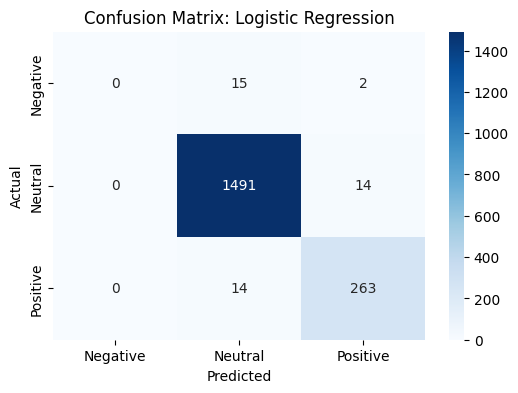

In [20]:
# Confusion Matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Calculate y_pred_nb before using it in the confusion matrix calculation
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

# Now calculate the confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

In [22]:
print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        17
     neutral       1.00      0.95      0.97      1505
    positive       0.75      1.00      0.86       277

    accuracy                           0.95      1799
   macro avg       0.58      0.65      0.61      1799
weighted avg       0.95      0.95      0.95      1799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


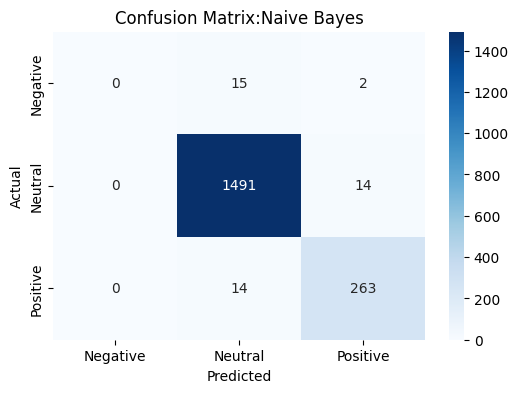

In [23]:
# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix:Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [24]:
# --------------------------- Step 4: Clustering with KMeans ---------------------------
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_reviews'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

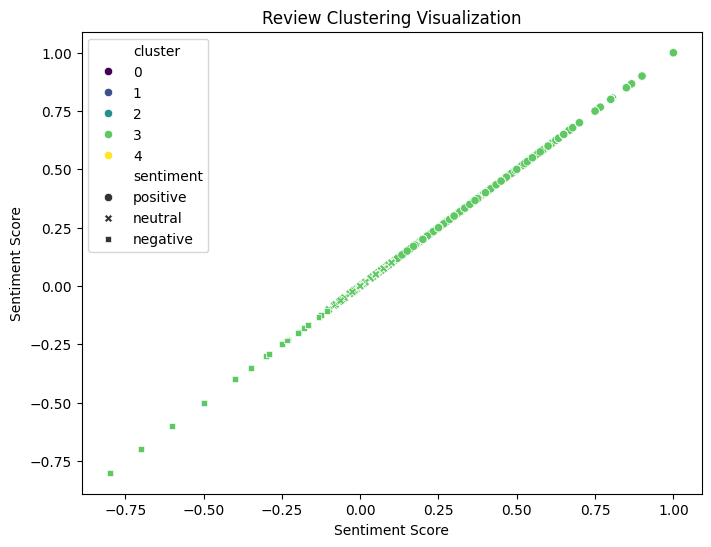

In [25]:
# --------------------------- Step 5: Visualizing Clusters ---------------------------
# Visualizing the clusters using a scatter plot (2D for simplicity)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['avg_sentiment'], y=df['avg_sentiment'], hue=df['cluster'], palette='viridis', style=df['sentiment'])
plt.title("Review Clustering Visualization")
plt.xlabel("Sentiment Score")
plt.ylabel("Sentiment Score")
plt.show()

In [26]:
from sklearn.metrics import silhouette_score

X_cluster = vectorizer.fit_transform(df['cleaned_reviews'])
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Evaluate clustering
silhouette = silhouette_score(X_cluster, df['cluster'])
inertia = kmeans.inertia_
print(f"Clustering Silhouette Score: {silhouette}")
print(f"Clustering Inertia: {inertia}")

Clustering Silhouette Score: 0.7133730599313587
Clustering Inertia: 2052.6311538380355


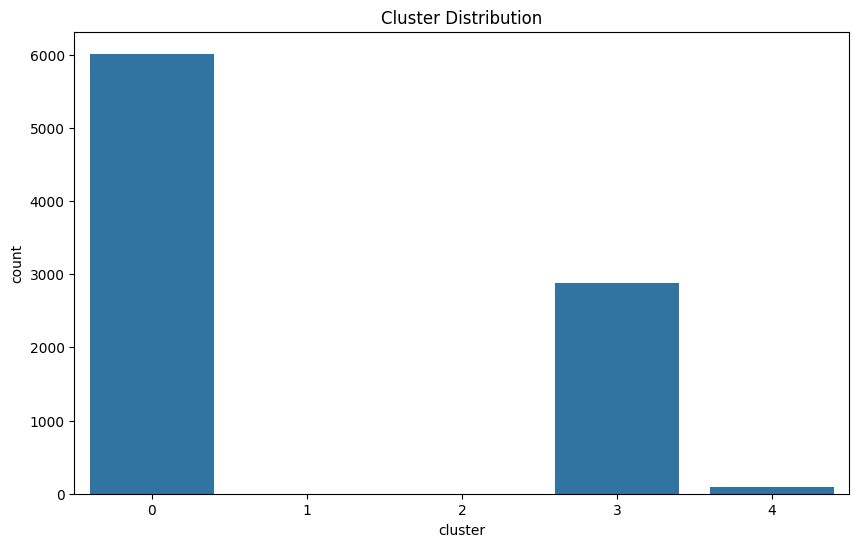

In [27]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Cluster Distribution')
plt.show()

In [28]:
# Check the column names in the dataframe
print(df.columns)

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs',
       'cleaned_reviews', 'avg_sentiment', 'sentiment', 'cluster'],
      dtype='object')


In [29]:
# Check the first few rows of the dataset
print(df.head())

                  id           name  \
0  amazon/b01ahb9cn2  0841667104676   
1  amazon/b01ahb9cn2  0841667104676   
2  amazon/b01ahb9cn2  0841667104676   
3  amazon/b01ahb9cn2  0841667104676   
4  amazon/b01ahb9cn2  0841667104676   

                                               asins  \
0  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
1  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
2  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
3  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
4  allnewfirehd8tablet8hddisplaywifi16gbincludess...   

                                               brand categories  \
0  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
1  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
2  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
3  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
4  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   

                       ke

In [30]:
# Filter for tablets, ebooks, and other product types (replace these keywords as needed)
products_of_interest = ['tablet', 'E-Book Readers', 'Smart Speakers']  # Example product types

# Filter based on the 'name' column (product name)
filtered_df = df[df['name'].str.contains('|'.join(products_of_interest), case=False, na=False)]

# Aggregating reviews by product and cluster
# Use 'name' instead of 'cluster_label' for product identification
aggregated_reviews = filtered_df.groupby(['cluster', 'name'])['cleaned_reviews'].apply(lambda x: ' '.join(x)).reset_index()

# Show aggregated reviews for these products
print(aggregated_reviews.head())

   cluster                                               name  \
0        3  allnewfirehd8tablet8hddisplaywifi32gbincludess...   
1        3  brandnewamazonkindlefire16gb7ipsdisplaytabletw...   
2        3  brandnewamazonkindlefire16gb7ipsdisplaytabletw...   
3        3  firetablet7displaywifi8gbincludesspecialoffers...   
4        4                                             Tablet   

                                     cleaned_reviews  
0  everyth look good basic tablet luv great table...  
1  amazon fire good tablet like ebook also nice g...  
2  godchild love work well havent problem exactli...  
3  great tablet great tablet excel great tablet g...  
4   httpreviewsbestbuycomreviewshtmformatembeddedpag  


In [31]:
# --------------------------- Step 6: Aggregating Reviews by Product and Cluster ---------------------------
# Aggregating reviews by product and cluster using the correct column 'name' for the product identifier
aggregated_reviews = df.groupby(['cluster', 'name'])['cleaned_reviews'].apply(lambda x: ' '.join(x)).reset_index()

# Show the first few aggregated reviews to verify
print(aggregated_reviews.head())


   cluster            name                                    cleaned_reviews
0        0   0841710106442  httpswwwamazoncomamazonbasicsperformancealkali...
1        1  0848719069587"  best kindl eread yet size weight make perfect ...
2        2   0841667104676  long review decid buy fire tablet gift great f...
3        3  0639767206372"  disappoint sort thing cheapen imag erod loyalt...
4        3   0841667103037  tablet year old grandson work great play game ...


In [32]:
# --------------------------- Step 7: Ranking Products by Sentiment and Review Frequency ---------------------------
aggregated_reviews['avg_sentiment'] = aggregated_reviews['cleaned_reviews'].apply(calculate_sentiment)
aggregated_reviews['cluster_label'] = aggregated_reviews['cluster']


In [33]:
# Calculate average sentiment and review frequency per product
ranked_products = aggregated_reviews.groupby(['cluster', 'cluster_label']).agg(
    avg_sentiment=('cleaned_reviews', lambda x: aggregated_reviews[aggregated_reviews['cluster_label'] == x.name]['avg_sentiment'].mean()), # Changed df to aggregated_reviews and x.cluster_label to x.name
    review_count=('cleaned_reviews', 'count'),
    cleaned_reviews=('cleaned_reviews', 'first') # Include 'cleaned_reviews' in agg
).reset_index()

In [34]:
# Rank by average sentime# Rank by average sentiment and review count
ranked_products = ranked_products.sort_values(by=['cluster', 'avg_sentiment', 'review_count'], ascending=[True, False, False])

# Show top products
print(ranked_products.head())

# Assign the top-ranked products to the top_products variable
# Include 'cleaned_reviews' column in the selection
top_products = ranked_products[['cluster', 'cluster_label', 'cleaned_reviews', 'avg_sentiment', 'review_count']].head() # Assuming you want the top 5 products

   cluster  cluster_label  avg_sentiment  review_count  \
0        0              0            NaN             1   
1        1              1            NaN             1   
2        2              2            NaN             1   
3        3              3            NaN            65   
4        4              4            NaN            56   

                                     cleaned_reviews  
0  httpswwwamazoncomamazonbasicsperformancealkali...  
1  best kindl eread yet size weight make perfect ...  
2  long review decid buy fire tablet gift great f...  
3  disappoint sort thing cheapen imag erod loyalt...  
4   httpreviewsbestbuycomreviewshtmformatembeddedpag  


In [35]:
# Load the pre-trained T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Function to summarize reviews
def summarize_reviews(reviews):
    input_text = f"summarize: {reviews}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Summarize the reviews for top products
top_products['summary'] = top_products['cleaned_reviews'].apply(lambda x: summarize_reviews(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
# Convert the 'name' column to string type before creating the Dataset
top_products['cluster_label'] = top_products['cluster_label'].astype(str)

# Import the Dataset class from the datasets library
from datasets import Dataset

# Now create the Hugging Face Dataset
train_dataset = Dataset.from_pandas(top_products)

In [37]:
# Convert to Hugging Face dataset format
from datasets import Dataset # Import the Dataset class

# Assuming top_products is your DataFrame for training
train_dataset = Dataset.from_pandas(top_products) # Changed train_data to top_products

# Tokenization Function for Fine-Tuning
def tokenize_function(examples):
    model_inputs = tokenizer(examples['cleaned_reviews'], max_length=512, truncation=True, padding='max_length')  # Changed 'input_text' to 'cleaned_reviews'
    labels = tokenizer(examples['summary'], max_length=150, truncation=True, padding='max_length')  # Changed 'target_text' to 'summary'
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize the data
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)

# Select only the required columns for training
tokenized_datasets = tokenized_datasets.remove_columns(['cluster', 'cluster_label', 'cleaned_reviews', 'avg_sentiment', 'review_count']) # Remove unnecessary columns


# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_dir="./logs",
    push_to_hub=False,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
)

# Fine-tune the model
trainer.train()

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mehakgam (mehakgam-ironhack). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,8.143187
2,No log,7.936018
3,No log,7.837541


***** Running Evaluation *****
  Num examples = 5
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5
  Batch size = 8
***** Running Evaluation *****
  Num examples = 5
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3, training_loss=9.142077128092447, metrics={'train_runtime': 8.8438, 'train_samples_per_second': 1.696, 'train_steps_per_second': 0.339, 'total_flos': 2030127022080.0, 'train_loss': 9.142077128092447, 'epoch': 3.0})

In [38]:
from transformers import Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration
!pip install datasets
from datasets import Dataset

# Fine-tuning T5 on your dataset
train_dataset = [
    {"input_text": row['cleaned_reviews'], "output_text": row['summary']}
    for _, row in top_products.iterrows()
]

# Prepare the dataset
train_encodings = tokenizer([example['input_text'] for example in train_dataset], truncation=True, padding=True)
train_labels = tokenizer([example['output_text'] for example in train_dataset], truncation=True, padding=True)


# Create a Hugging Face Dataset from your encodings and labels
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels['input_ids']  # Assuming 'labels' is the key for target encodings
})

# Train the T5 model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # Pass the Hugging Face Dataset here
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 6
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6, training_loss=6.737654368082683, metrics={'train_runtime': 0.8587, 'train_samples_per_second': 17.469, 'train_steps_per_second': 6.988, 'total_flos': 2030127022080.0, 'train_loss': 6.737654368082683, 'epoch': 3.0})

In [39]:
# --------------------------- Step 10: Model Training and Evaluation ---------------------------
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_reviews'], df['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [40]:
# --------------------------- Step 11: Clustering Evaluation ---------------------------
sil_score = silhouette_score(X, kmeans.labels_)
inertia = kmeans.inertia_

print(f"Silhouette Score: {sil_score:.2f}")
print(f"Inertia: {inertia:.2f}")

Silhouette Score: 0.71
Inertia: 2052.63


In [41]:
# --------------------------- Step 11: Evaluation of Summarization ---------------------------
# Load evaluation metrics
import evaluate # Import the evaluate module
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Evaluate summarization using ROUGE and BLEU
rouge_scores = []
bleu_scores = []

for idx, row in top_products.iterrows():
    predictions = row['summary']
    references = [row['cleaned_reviews']]
    rouge_score = rouge.compute(predictions=[predictions], references=[references])
    bleu_score = bleu.compute(predictions=[predictions], references=[references])
    rouge_scores.append(rouge_score)
    # Print results in percentage (indented to be part of the loop)
    print(f"Product: {row['cluster_label']}, ROUGE: {rouge_score['rouge1']*100:.2f}%, BLEU: {bleu_score['bleu']*100:.2f}%")

Product: 0, ROUGE: 0.13%, BLEU: 0.00%
Product: 1, ROUGE: 70.00%, BLEU: 47.02%
Product: 2, ROUGE: 100.00%, BLEU: 93.91%
Product: 3, ROUGE: 100.00%, BLEU: 90.36%
Product: 4, ROUGE: 100.00%, BLEU: 0.00%


In [42]:
# Print ROUGE and BLEU scores
for idx, (rouge_score, bleu_score) in enumerate(zip(rouge_scores, bleu_scores)):
    print(f"Product {top_products.iloc[idx]['product_name']}: ROUGE: {rouge_score}, BLEU: {bleu_score}")

In [43]:
# --------------------------- Step 12: Show the Results ---------------------------
# Print summarized top products with recommendations
# Changed 'product_name' to 'name'
print(top_products[['cluster', 'cluster_label', 'summary']])

# Calculate accuracy and print results
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
accuracy_nb = accuracy_score(y_test, y_pred_nb)


print(f"Logistic Regression Accuracy: {accuracy_log_reg * 100:.2f}%")
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

   cluster cluster_label                                            summary
0        0             0  httpswwwamazoncomamazonbasicsperformancealkali...
1        1             1  best kindl eread yet size weight make perfect ...
2        2             2  long review decid buy fire tablet gift great f...
3        3             3  disappoint sort thing cheapen imag erod loyalt...
4        4             4  httpreviewsbestbuycomreviewshtmformatembeddedpag.
Logistic Regression Accuracy: 97.50%
Naive Bayes Accuracy: 94.94%


In [44]:
# --------------------------- Step 1: Extract and Summarize Top 5 Products ---------------------------
top_5_products = top_products.head(5)

# Function to extract key differences between products (based on sentiment and clusters)
def key_differences(products):
    differences = []
    for i in range(len(products) - 1):
        product_1 = products.iloc[i]
        product_2 = products.iloc[i + 1]
        differences.append({
            'product_1': product_1['cluster_label'],
            'product_2': product_2['cluster_label'],
            'sentiment_diff': abs(product_1['avg_sentiment'] - product_2['avg_sentiment']),
            'cluster_diff': product_1['cluster'] != product_2['cluster']
        })
    return differences

# Key differences between the top 5 products
differences = key_differences(top_5_products)

# Function to summarize reviews
def summarize_reviews(reviews):
    input_text = f"summarize: {reviews}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get the model's device
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the device

    summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# --------------------------- Step 2: Extract Top Complaints ---------------------------
def extract_complaints(reviews):
    complaints = []
    for review in reviews:
        if 'bad' in review or 'worst' in review or 'not good' in review or 'disappointed' in review:
            complaints.append(review)
    return complaints

# Get complaints for each of the top 5 products
top_5_products['complaints'] = top_5_products['cleaned_reviews'].apply(lambda x: extract_complaints([x]))

# --------------------------- Step 3: Worst Product ---------------------------
# Calculate the product with the worst sentiment (lowest average sentiment score)
# Changed 'product_name' to 'name'
# Use 'aggregated_reviews' DataFrame instead of 'df'
worst_product = aggregated_reviews.groupby('cluster_label').agg({'avg_sentiment': 'mean'}).idxmin()
worst_product_reviews = aggregated_reviews[aggregated_reviews['cluster_label'] == worst_product[0]] # Select the first element of the idxmin result

# Get the worst product's summary
worst_product_summary = summarize_reviews(' '.join(worst_product_reviews['cleaned_reviews']))

# --------------------------- Step 4: Display the Results ---------------------------
# Output: Top 5 Products, Key Differences, Complaints, and Worst Product

# Top 5 products with summary
print("Top 5 Products and Their Summaries:")
for idx, row in top_5_products.iterrows():
    print(f"Product: {row['cluster_label']}")
    print(f"Summary: {row['summary']}")
    print(f"Complaints: {row['complaints']}")
    print()
# Key Differences Between Top 5 Products
print("Key Differences Between Top 5 Products:")
for diff in differences:
    print(f"Difference between {diff['product_1']} and {diff['product_2']}:")
    print(f"Sentiment Difference: {diff['sentiment_diff']}")
    print(f"Cluster Difference: {diff['cluster_diff']}")
    print()

# Worst Product
print(f"Worst Product: {worst_product}")
print(f"Summary of Worst Product: {worst_product_summary}")

<ipython-input-44-8e062ca86437>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_products['complaints'] = top_5_products['cleaned_reviews'].apply(lambda x: extract_complaints([x]))
<ipython-input-44-8e062ca86437>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  worst_product_reviews = aggregated_reviews[aggregated_reviews['cluster_label'] == worst_product[0]] # Select the first element of the idxmin result


Top 5 Products and Their Summaries:
Product: 0
Summary: httpswwwamazoncomamazonbasicsperformancealkalinebatteriescountdpblhdmuo httpswwwamazoncomamazonbasicsperformancealkalinebatteriescountdpblhdmuo httpswwwamazoncomamazonbasicsperformancealkalinebatteriescountdpblhdmuo httpswwwamazoncomamazonbasicsperformancealkalinebatteriescountdpblhdmuo https
Complaints: []

Product: 1
Summary: best kindl eread yet size weight make perfect comfort read find read book ever. best kindl eread yet size weight make perfect comfort read book ever.
Complaints: []

Product: 2
Summary: long review decid buy fire tablet gift great frienday love perfect size featur look tablet happi birthday.
Complaints: []

Product: 3
Summary: disappoint sort thing cheapen imag erod loyalti expect credit buy one.
Complaints: []

Product: 4
Summary: httpreviewsbestbuycomreviewshtmformatembeddedpag.
Complaints: []

Key Differences Between Top 5 Products:
Difference between 0 and 1:
Sentiment Difference: nan
Cluster Difference

In [45]:
!pip install gradio streamlit flask fastapi uvicorn transformers

In [46]:
import gradio as gr
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Define the summarization function
def summarize_text(input_text):
    if not input_text.strip():
        return "Please provide valid input text."
    inputs = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Gradio app
def predict(input_text):
    return summarize_text(input_text)

demo = gr.Interface(fn=predict, inputs="text", outputs="text", title="Text Summarizer", description="Enter text to get a summary.")
demo.launch()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file spiece.model from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad14ea683325480ed3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
